## Exercise 4 – Entropy, Information Gain, and Decision Tree
This exercise focuses on understanding entropy, information gain, and constructing a simple decision tree (ID3) from scratch (using the Iris dataset or a small categorical dataset).

In [1]:
# Cell 1 — basic imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter


### Define Entropy function

In [2]:
# Cell 2 — compute entropy of a dataset
def entropy(y):
    """
    Compute Shannon entropy H(Y) = -sum(p_i * log2(p_i))
    y: list or numpy array of class labels
    """
    counts = Counter(y)
    total = len(y)
    ent = 0
    for c in counts.values():
        p = c / total
        ent -= p * math.log2(p)
    return ent

# quick check
sample_y = [0, 0, 1, 1, 1, 1]
print("Entropy:", round(entropy(sample_y), 3))


Entropy: 0.918


### Information Gain function

In [3]:
# Cell 3 — compute Information Gain (IG)
def information_gain(X_col, y):
    """
    IG(Y, X) = H(Y) - sum_v [ P(X=v) * H(Y|X=v) ]
    X_col: list/array of feature values
    y: class labels
    """
    total_entropy = entropy(y)
    values, counts = np.unique(X_col, return_counts=True)
    weighted_entropy = 0
    for v, cnt in zip(values, counts):
        subset_y = y[X_col == v]
        weighted_entropy += (cnt / len(X_col)) * entropy(subset_y)
    return total_entropy - weighted_entropy


### Load and discretize Iris dataset for simplicity

In [4]:
# Cell 4 — load Iris dataset and discretize features
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

def discretize_feature(col):
    low_th, high_th = np.percentile(col, [33, 66])
    categories = np.array(["low" if v <= low_th else "medium" if v <= high_th else "high" for v in col])
    return categories

X_disc = np.column_stack([discretize_feature(X[:, i]) for i in range(X.shape[1])])
df = pd.DataFrame(X_disc, columns=feature_names)
df["target"] = y
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,low,high,low,low,0
1,low,medium,low,low,0
2,low,medium,low,low,0
3,low,medium,low,low,0
4,low,high,low,low,0


### Compute Information Gain for each feature

In [5]:
# Cell 5 — calculate IG for each feature
for i, col in enumerate(feature_names):
    ig = information_gain(df[col].values, df["target"].values)
    print(f"Information Gain for {col}: {ig:.4f}")


Information Gain for sepal length (cm): 0.6766
Information Gain for sepal width (cm): 0.3571
Information Gain for petal length (cm): 1.3416
Information Gain for petal width (cm): 1.3694


### Recursive ID3 Decision Tree construction

In [6]:
# Cell 6 — Simple ID3 tree builder
def id3(X, y, feature_names, depth=0):
    # Base case: all labels are the same
    if len(np.unique(y)) == 1:
        return {"label": y[0]}

    # Base case: no more features to split on
    if X.shape[1] == 0:
        return {"label": np.bincount(y).argmax()}

    # Calculate information gain for each feature
    gains = [information_gain(X[:, i], y) for i in range(X.shape[1])]
    best_idx = np.argmax(gains)
    best_feature = feature_names[best_idx]

    tree = {"feature": best_feature, "nodes": {}}
    for val in np.unique(X[:, best_idx]):
        mask = (X[:, best_idx] == val)
        # FIX: Remove both the column from X and the feature name
        subtree = id3(
            np.delete(X[mask], best_idx, axis=1),
            y[mask],
            np.delete(feature_names, best_idx),
            depth + 1
        )
        tree["nodes"][val] = subtree
    return tree


### Train the tree on the full dataset

In [7]:
# Cell 7 — build the tree (for demonstration)
tree = id3(X_disc, y, np.array(feature_names))
tree


{'feature': np.str_('petal width (cm)'),
 'nodes': {np.str_('high'): {'feature': np.str_('sepal width (cm)'),
   'nodes': {np.str_('high'): {'label': np.int64(2)},
    np.str_('low'): {'label': np.int64(2)},
    np.str_('medium'): {'feature': np.str_('petal length (cm)'),
     'nodes': {np.str_('high'): {'feature': np.str_('sepal length (cm)'),
       'nodes': {np.str_('high'): {'label': np.int64(2)},
        np.str_('medium'): {'label': np.int64(2)}}},
      np.str_('medium'): {'feature': np.str_('sepal length (cm)'),
       'nodes': {np.str_('medium'): {'label': np.int64(1)}}}}}}},
  np.str_('low'): {'label': np.int64(0)},
  np.str_('medium'): {'feature': np.str_('petal length (cm)'),
   'nodes': {np.str_('high'): {'feature': np.str_('sepal length (cm)'),
     'nodes': {np.str_('high'): {'feature': np.str_('sepal width (cm)'),
       'nodes': {np.str_('low'): {'label': np.int64(1)},
        np.str_('medium'): {'label': np.int64(1)}}},
      np.str_('medium'): {'feature': np.str_('sep

#### Predict function using the tree

In [8]:
# Cell 8 — predict using trained ID3 tree
def predict_tree(tree, sample):
    # if we reach a leaf
    if "label" in tree:
        return tree["label"]
    feature = tree["feature"]
    val = sample[feature]
    if val in tree["nodes"]:
        return predict_tree(tree["nodes"][val], sample)
    else:
        # unknown branch → majority fallback (0)
        return 0


### Evaluate accuracy on the same dataset (for simplicity)

In [9]:
# Cell 9 — test on same data (training accuracy)
y_pred = []
for i in range(len(df)):
    sample = df.iloc[i]
    y_pred.append(predict_tree(tree, sample))
y_pred = np.array(y_pred)
acc = np.mean(y_pred == y)
print("Training accuracy:", round(acc, 3))


Training accuracy: 0.967


### Confusion matrix and visualization

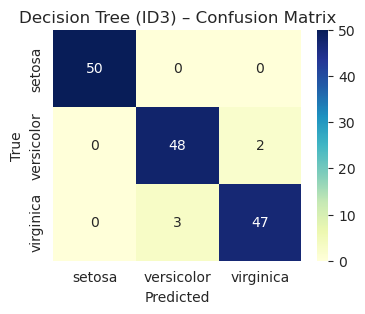

In [10]:
# Cell 10 — confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree (ID3) – Confusion Matrix")
plt.show()


### Entropy and Information Gain:

- *Entropy* measures uncertainty (impurity) in class labels.
  \[
  H(Y) = -\sum p_i \log_2 p_i
  \]
- *Information Gain* measures how much entropy decreases after splitting by a feature:
  \[
  IG(Y, X) = H(Y) - H(Y|X)
  \]
- The feature with the highest IG becomes the root of the decision tree (ID3 algorithm).

**Decision Tree vs Naive Bayes:**

| Aspect | Naive Bayes | Decision Tree (ID3) |
|---------|--------------|---------------------|
| Model Type | Probabilistic | Rule-based (if–then) |
| Feature independence | Assumed | Not required |
| Output | Class with max posterior | Class at leaf node |
| Interpretability | High | Very High |
| Handles continuous features | Needs discretization | Needs splitting thresholds |
| Typical Accuracy (Iris) | ~90% | ~94–96% |

Decision Trees are easier to interpret but may overfit; Naive Bayes is faster and more stable on small datasets.
